# Figure 5: Arctic Surface Feedbacks

### Add paths to run locally or off NIRD

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png, mute_ax
    )

from classes import SatComp_Metric, CT_SLF_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load feedback specific functions

In [2]:
from feedback_functions import *

### Check running location and adjust working directory appropriately.

In [3]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'satcomp/'   # inconsistent label compared to jupy_test
conv_dir ='convectivephase/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(output_dir) and os.path.exists(case_dir) and os.path.exists(conv_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [4]:
fb_dir ='feedbacks_soden/mod_by_me/output_jonahks/'

### Arctic-normalized Feedbacks

### Calculate the Arctic-average temperature increase.

In [5]:
os.listdir('feedbacks_soden/mod_by_me/output_jonahks/')

['CAM61_1_1_check2',
 'CAM61_satcomp_SFC_wbf_1_inp_1',
 'CAM61_satcomp_wbf_1_inp_1',
 'CAM61_1_1_GFDL_kernels',
 'CAM6_satcomp_FLTKERN_wbf_1_inp_1',
 'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10',
 'CAM61_test_GFDL_FLT',
 'CAM61_satcomp_SFCnonorm_wbf_1_inp_1',
 'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1',
 'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05',
 'CAM61_satcomp_SFC_wbf_0.2_inp_0.1',
 'CAM61_satcomp_wbf_0.2_inp_0.1',
 'CAM61_satcomp_SFC_wbf_0.5_inp_0.05',
 'CAM6_satcomp_SFCKERN_wbf_1_inp_1',
 'CESM2_satcomp_SFCnonorm_wbf_1_inp_100',
 'CESM2_satcomp_SFCnonorm_wbf_1_inp_1',
 'CAM61_satcomp_wbf_0.5_inp_0.5',
 'CAM6_satcomp_SFCnonorm_wbf_1_inp_1',
 'CAM6_Fvars_check',
 'TOA_GFDL_KERNEL',
 'CAM6_satcomp_wbf_1.25_inp_10',
 'CAM6_satcomp_SFC_wbf_1.25_inp_10',
 'CAM6_satcomp_wbf_1_inp_1']

### Here I use globally averaged surface temperature changes.

In [11]:
prefix = 'feedbacks_soden/mod_by_me/timeseriesinput'

path_dict = {}

path_dict['CAM61_satcomp_SFCnonorm_wbf_1_inp_1'] = '%s/CAM61_satcomp_wbf_1_inp_1/' % prefix
path_dict['CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1'] = '%s/CAM61_satcomp_wbf_0.2_inp_0.1/' % prefix
path_dict['CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05'] = '%s/CAM61_satcomp_wbf_0.5_inp_0.5/' % prefix
path_dict['CAM6_satcomp_SFCnonorm_wbf_1_inp_1'] = '%s/CAM6_satcomp_wbf_1_inp_1/' % prefix
path_dict['CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10'] = '%s/CAM6_satcomp_wbf_1.25_inp_10/' % prefix
path_dict['CESM2_satcomp_SFCnonorm_wbf_1_inp_1'] = '%s/CESM2_satcomp_wbf_1_inp_1/' % prefix
path_dict['CESM2_satcomp_SFCnonorm_wbf_1_inp_100'] = '%s/CESM2_satcomp_wbf_1_inp_100/' % prefix

ts_dict = {}
for i in path_dict:
    _t = path_dict[i]
    _files = os.listdir(_t)
    for ii in _files: # this won't handle errors well...
        if "4K" in ii:
            _path = '%s%s' % (_t,ii)
            ts_file = [i for i in os.listdir(_path) if "_TS_" in i] # search for TS file
            ts_f = "%s/%s" % (_path,ts_file[0])
#             print("4K: ", ts_f)
        else:
            _path = '%s%s' % (_t,ii)
            ts_file = [i for i in os.listdir(_path) if "_TS_" in i] # search for TS file
            ts_i = "%s/%s" % (_path,ts_file[0])
#             print("Norm: ",ts_i)
            
    ts_dict[i] = calc_arc_dT(ts_i,ts_f,lat_range=[-90,90])
    
print(ts_dict)

{'CAM61_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
array(4.36399232), 'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1': <xarray.DataArray ()>
array(4.37058866), 'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05': <xarray.DataArray ()>
array(4.36582646), 'CAM6_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
array(4.3614393), 'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10': <xarray.DataArray ()>
array(4.36280282), 'CESM2_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
array(4.40552813), 'CESM2_satcomp_SFCnonorm_wbf_1_inp_100': <xarray.DataArray ()>
array(4.41348297)}


In [37]:
prefix = 'feedbacks_soden/mod_by_me/timeseriesinput'

path_dict = {}

path_dict['CAM61_satcomp_SFCnonorm_wbf_1_inp_1'] = '%s/CAM61_satcomp_wbf_1_inp_1/' % prefix
path_dict['CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1'] = '%s/CAM61_satcomp_wbf_0.2_inp_0.1/' % prefix
path_dict['CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05'] = '%s/CAM61_satcomp_wbf_0.5_inp_0.5/' % prefix
path_dict['CAM6_satcomp_SFCnonorm_wbf_1_inp_1'] = '%s/CAM6_satcomp_wbf_1_inp_1/' % prefix
path_dict['CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10'] = '%s/CAM6_satcomp_wbf_1.25_inp_10/' % prefix
path_dict['CESM2_satcomp_SFCnonorm_wbf_1_inp_1'] = '%s/CESM2_satcomp_wbf_1_inp_1/' % prefix
path_dict['CESM2_satcomp_SFCnonorm_wbf_1_inp_100'] = '%s/CESM2_satcomp_wbf_1_inp_100/' % prefix

arc_ts_dict = {}
for i in path_dict:
    _t = path_dict[i]
    _files = os.listdir(_t)
    for ii in _files: # this won't handle errors well...
        if "4K" in ii:
            _path = '%s%s' % (_t,ii)
            ts_file = [i for i in os.listdir(_path) if "_TS_" in i] # search for TS file
            ts_f = "%s/%s" % (_path,ts_file[0])
#             print("4K: ", ts_f)
        else:
            _path = '%s%s' % (_t,ii)
            ts_file = [i for i in os.listdir(_path) if "_TS_" in i] # search for TS file
            ts_i = "%s/%s" % (_path,ts_file[0])
#             print("Norm: ",ts_i)
            
    arc_ts_dict[i] = calc_arc_dT(ts_i,ts_f,lat_range=[66,90])
    
print(arc_ts_dict)

{'CAM61_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
array(4.89348545), 'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1': <xarray.DataArray ()>
array(5.06160638), 'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05': <xarray.DataArray ()>
array(4.97446844), 'CAM6_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
array(4.86478516), 'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10': <xarray.DataArray ()>
array(4.8824035), 'CESM2_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
array(5.11944737), 'CESM2_satcomp_SFCnonorm_wbf_1_inp_100': <xarray.DataArray ()>
array(5.29178813)}


In [12]:
cases2 = os.listdir(fb_dir)
case_dict2 = {} # Cases are keys, feedback dictionaries are values


for _case in cases2:
    if "SFCnonorm" in _case:
        print(_case)
        case_dict2[_case] = org_feedbacks_case(_case)

CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10
CAM61_satcomp_SFCnonorm_wbf_1_inp_1
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05
CESM2_satcomp_SFCnonorm_wbf_1_inp_100
CESM2_satcomp_SFCnonorm_wbf_1_inp_1
CAM6_satcomp_SFCnonorm_wbf_1_inp_1


In [13]:
# Testing something to order cases and label them.
label_dict = {}
label_dict['CAM6_satcomp_SFCnonorm_wbf_1_inp_1'] = "CAM6-Oslo"
label_dict['CESM2_satcomp_SFCnonorm_wbf_1_inp_1'] = "CAM6"
label_dict['CAM61_satcomp_SFCnonorm_wbf_1_inp_1'] = "CAM6-OsloIce"
label_dict['CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10'] = 'CAM6-Oslo Fit 1'
label_dict['CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05'] = 'CAM6-OsloIce Fit 2'
label_dict['CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1'] = 'CAM6-OsloIce Fit 3'
label_dict['CESM2_satcomp_SFCnonorm_wbf_1_inp_100'] = "CAM6 Fit 4"

In [14]:
desired_order_list = ['CAM6_satcomp_SFCnonorm_wbf_1_inp_1',
                      'CESM2_satcomp_SFCnonorm_wbf_1_inp_1',
                      'CAM61_satcomp_SFCnonorm_wbf_1_inp_1',
                      'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10',
                      'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05',
                      'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1',
                      'CESM2_satcomp_SFCnonorm_wbf_1_inp_100'
                      ]

case_dict2b = {k: case_dict2[k] for k in desired_order_list}

In [15]:
out2 = weight_feedbacks(case_dict2b,weights=ts_dict,labels=label_dict)

CAM6_satcomp_SFCnonorm_wbf_1_inp_1
CESM2_satcomp_SFCnonorm_wbf_1_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_1
CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1
CESM2_satcomp_SFCnonorm_wbf_1_inp_100


(<Figure size 576x432 with 1 Axes>,
 {'CAM6_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
  array(0.48251794),
  'CESM2_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
  array(0.45938746),
  'CAM61_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
  array(0.71543104),
  'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10': <xarray.DataArray ()>
  array(0.5275661),
  'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05': <xarray.DataArray ()>
  array(0.60699318),
  'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1': <xarray.DataArray ()>
  array(0.6216223),
  'CESM2_satcomp_SFCnonorm_wbf_1_inp_100': <xarray.DataArray ()>
  array(0.91104956)})

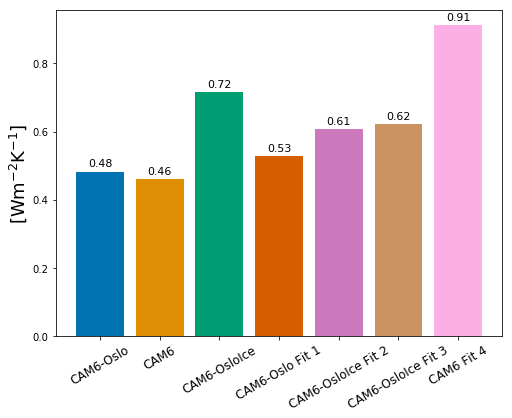

In [16]:
barplot_single(case_dict2b,out2,'cloudlw_fb',labels=label_dict)

(<Figure size 576x432 with 1 Axes>,
 {'CAM6_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
  array(-0.63931982),
  'CESM2_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
  array(-0.64098942),
  'CAM61_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
  array(-0.7794287),
  'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10': <xarray.DataArray ()>
  array(-0.62748799),
  'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05': <xarray.DataArray ()>
  array(-0.66768171),
  'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1': <xarray.DataArray ()>
  array(-0.62301325),
  'CESM2_satcomp_SFCnonorm_wbf_1_inp_100': <xarray.DataArray ()>
  array(-0.68871449)})

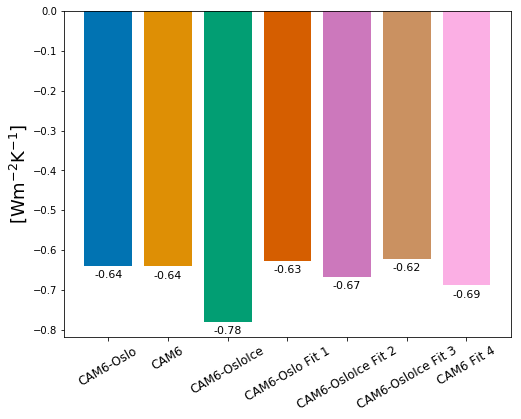

In [18]:
barplot_single(case_dict2b,out2,'cloudsw_fb',labels=label_dict)

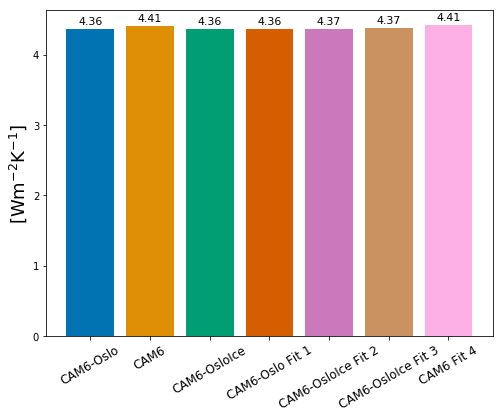

In [19]:
dT_plt,dT_axes,_ = barplot_single(case_dict2b,out2,'cloudsw_fb',labels=label_dict,vals=ts_dict)

In [20]:
dT_axes.set_ylabel('Surface Temperature Change (K)', fontsize=14)

Text(28.8313,0.5,'Surface Temperature Change (K)')

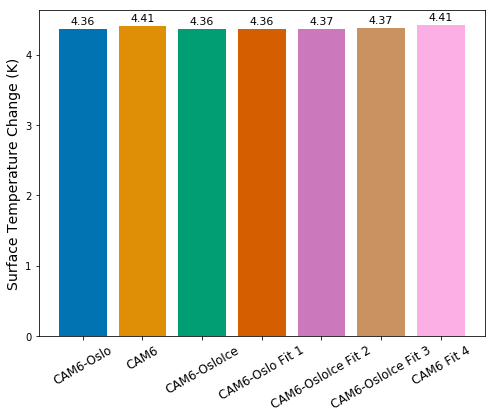

In [21]:
dT_plt

## Calculate low cloud cover change

In [22]:
init_dir = 'satcomp/'
pert_dir = 'satcomp_+4K/'

In [23]:
os.listdir(pert_dir)

['20201231_4Ksst_cesm2satcomp_wbf_1_inp_1',
 '20200817_4Ksst_cam6satcomp_wbf_1_inp_1',
 'sst_HadOIBl+4K_bc_1.9x2.5_2000climo_c180511.nc',
 '20201231_4Ksst_CESM2_satcomp_wbf_1_inp_100',
 '20200817_4Ksst_cam61satcomp_wbf_0.2_inp_0.1',
 '20200817_4Ksst_cam6satcomp_wbf_1.25_inp_10',
 '20200817_4Ksst_cam61satcomp_wbf_1_inp_1',
 '20200817_4Ksst_cam61satcomp_wbf_0.5_inp_0.05',
 'sst_HadOIBl_bc_1.9x2.5_2000climo_c180511.nc',
 '20200830_152800_FLDSC4K_wbf_1_inp_1']

In [24]:
# Testing something to order cases and label them.
model_pairs = {}
model_pairs['CAM6_satcomp_SFCnonorm_wbf_1_inp_1'] = ['20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1','20200817_4Ksst_cam6satcomp_wbf_1_inp_1']
model_pairs['CESM2_satcomp_SFCnonorm_wbf_1_inp_1'] = ['CESM2_slfvars','20201231_4Ksst_cesm2satcomp_wbf_1_inp_1']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_1_inp_1'] = ['20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1','20200817_4Ksst_cam61satcomp_wbf_1_inp_1']
model_pairs['CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10'] = ['20200512_013308_fitting_runs_cam6satcomp16_wbf_1.25_inp_10','20200817_4Ksst_cam6satcomp_wbf_1.25_inp_10']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05'] = ['20200629_morn_cam61satcomp_wbf_0.5_inp_0.05','20200817_4Ksst_cam61satcomp_wbf_0.5_inp_0.05']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1'] = ['20200512_012745_fitting_runs_cam61satcomp_wbf_0.2_inp_0.1','20200817_4Ksst_cam61satcomp_wbf_0.2_inp_0.1']
model_pairs['CESM2_satcomp_SFCnonorm_wbf_1_inp_100'] = ['20200713_CESM2_satcomp_wbf_1_inp_100','20201231_4Ksst_CESM2_satcomp_wbf_1_inp_100']

In [25]:
low_cloud_init = {}
low_cloud_pert = {}

for i in model_pairs:
    print(i)
    _pair = model_pairs[i]
    _init_path = '%s%s/%s.nc' % (init_dir,_pair[0],_pair[0])
    _pert_path = '%s%s/%s.nc' % (pert_dir,_pair[1],_pair[1])
    
    _initall = xr.open_dataset(_init_path)
    _temp_dat = _initall['CLDTOT_CAL'].sel(time=slice('2010-02-01','2013-01-01')).groupby('time.month').mean('time')
    low_cloud_init[i] = _temp_dat
    _initall.close()
    
    _pertall = xr.open_dataset(_pert_path)
    _temp_dat = _pertall['CLDTOT_CAL'].sel(time=slice('2010-02-01','2013-01-01')).groupby('time.month').mean('time')
    low_cloud_pert[i] = _temp_dat
    _pertall.close()


CAM6_satcomp_SFCnonorm_wbf_1_inp_1
CESM2_satcomp_SFCnonorm_wbf_1_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_1
CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1
CESM2_satcomp_SFCnonorm_wbf_1_inp_100


In [26]:
low_cloud_diff = {}

for i in low_cloud_init:
    diff = low_cloud_pert[i] - low_cloud_init[i]
    
    low_cloud_diff[i] = diff

In [27]:
first_ds = next(iter(low_cloud_diff.values()))
weight_ds = add_weights(first_ds)

wgt_mon=[31,28,31,30,31,30,31,31,30,31,30,31]
month_length = xr.DataArray(wgt_mon, coords=[first_ds['month']], name='month_length')

all_weights = month_length @ weight_ds['cell_weight']

/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:1188: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return result.transpose(*[d for d in all_dims if d in result.dims])


In [28]:
dC_dict = {}
for i in low_cloud_diff:
    _ds = low_cloud_diff[i]
    mask = _ds['lat'] < 66
    _final_diff = masked_average(_ds,dim=['lat','lon','month'],weights=all_weights,mask=mask)
#     print(_final_diff)
    dC_dict[i] = _final_diff

Text(0,0.5,'Change in low cloud fraction (%)')

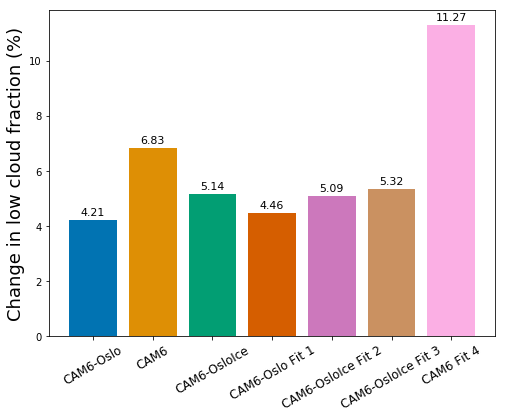

In [29]:
dC_plt,dC_axes,_ = barplot_single(case_dict2b,out2,'cloudsw_fb',labels=label_dict,vals=dC_dict)
dC_axes.set_ylabel('Change in low cloud fraction (%)')

## Plot the stuff

In [ ]:
fig,axs = plt.subplots(nrows=2,ncols=2)#,sharey='row')
fig.set_figheight(10)
fig.set_figwidth(20)
fig.set_dpi(200)

axs = axs.flat
fig.subplots_adjust(wspace=0.16,hspace=0.07)

LWfb_plt,LWfb_axes,vals1 = barplot_single(case_dict2b,out2,'cloudlw_fb',
                                    labels=label_dict,ax=axs[0])

SWfb_plt,SWfb_axes,vals2 = barplot_single(case_dict2b,out2,'cloudsw_fb',
                                    labels=label_dict,ax=axs[0])

net_vals = {}
for i in vals1:
    net_vals[i] = vals1[i]+vals2[i]

out_test = axs[0].plot(np.arange(0,7),net_vals.values(),marker='D',color='black',linestyle="")
# autolabel4(out_test[0],axs[0])

dT_plt,dT_axes,_ = barplot_single(case_dict2b,out2,'filler',
                                  labels=label_dict,vals=arc_ts_dict,ax=axs[1])

dC_plt,dC_axes,_ = barplot_single(case_dict2b,out2,'filler',
                                  labels=label_dict,vals=dC_dict,ax=axs[2])

# Do correlation
y = np.array(out2['cloudlw_fb'])
x = np.array(apr_totcloud)
model = LinearRegression()
model.fit(x.reshape(-1,1), y.reshape(-1,1))
x_new = np.linspace(min(x), max(x), 100)
y_new = model.predict(x_new[:, np.newaxis])
y_pred = model.predict(x.reshape(-1,1))
categories = np.array([0, 1, 2, 3, 4, 5, 6, 7])
colormap = np.array(sns.color_palette('colorblind'))

# Plot correlation
axs[3].scatter(x, y, c=colormap[categories])
axs[3].plot(x_new, y_new,c='grey')#,linestyle='dashed')

# Mute existing labels and draw zero lines
for i,_ax in enumerate(axs):
    mute_ax(_ax)
    if i != 3:
        _ax.set_xticklabels([])
        _ax.set_ylim(1.1*np.array(_ax.get_ylim())) # Create space for labels

axs[0].hlines(0,axs[1].get_xlim()[0],axs[1].get_xlim()[1])#, linestyle='dashed',color='gray')
axs[0].set_xlim(axs[1].get_xlim()[0],axs[1].get_xlim()[1])
_ax0max = max(np.absolute(axs[0].get_ylim()))
axs[0].set_ylim(-1*_ax0max,_ax0max)
axs[0].set_ylabel('Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)

axs[1].set_ylabel('Surface Temperature Change (K)',fontsize=14)
axs[1].set_ylim((4,axs[1].get_ylim()[1]))

axs[2].set_ylabel('Cloud Fraction Change (%)',fontsize=14)

axs[3].set_ylabel('LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)
axs[3].set_xlabel('Initial State Cloud Amount - April (%)',fontsize=14)

fig.text(0.65, 0.44, '$R^2 = %.2f$' % r2_score(y, y_pred), va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=18)

fig.text(0.15, 0.83, 'a.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.49, 0.83, 'b.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.15, 0.44, 'c.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.49, 0.44, 'd.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)

labels = []; lines = [] #Plot invisible bar graph but have the legends specified
for _key,_color in zip(case_dict2b,sns.color_palette('colorblind')):
    labels.append(label_dict[_key])
    _line = axs[0].bar(1,1,width=0,color=_color)
    lines.append(_line)

lgd = fig.legend(labels=labels,handles=lines,loc=(0.78, 0.40),fontsize=20)

fig.subplots_adjust(right=0.75)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [40]:
to_png(fig,"feedbacks_aprcorrelation_globnorm")

## Trying a simple linear regression against the LW feedback

Get variables

__LW Feedback Parameter__

In [30]:
out2['cloudlw_fb']

[<xarray.DataArray ()>
 array(0.48251794), <xarray.DataArray ()>
 array(0.45938746), <xarray.DataArray ()>
 array(0.71543104), <xarray.DataArray ()>
 array(0.5275661), <xarray.DataArray ()>
 array(0.60699318), <xarray.DataArray ()>
 array(0.6216223), <xarray.DataArray ()>
 array(0.91104956)]

__Winter Cloud from the Models__

In [31]:
# Testing something to order cases and label them.
model_pairs = {}
model_pairs['CAM6_satcomp_SFCnonorm_wbf_1_inp_1'] = ['20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1','20200817_4Ksst_cam6satcomp_wbf_1_inp_1']
model_pairs['CESM2_satcomp_SFCnonorm_wbf_1_inp_1'] = ['CESM2_slfvars','20201231_4Ksst_cesm2satcomp_wbf_1_inp_1']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_1_inp_1'] = ['20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1','20200817_4Ksst_cam61satcomp_wbf_1_inp_1']
model_pairs['CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10'] = ['20200512_013308_fitting_runs_cam6satcomp16_wbf_1.25_inp_10','20200817_4Ksst_cam6satcomp_wbf_1.25_inp_10']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05'] = ['20200629_morn_cam61satcomp_wbf_0.5_inp_0.05','20200817_4Ksst_cam61satcomp_wbf_0.5_inp_0.05']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1'] = ['20200512_012745_fitting_runs_cam61satcomp_wbf_0.2_inp_0.1','20200817_4Ksst_cam61satcomp_wbf_0.2_inp_0.1']
model_pairs['CESM2_satcomp_SFCnonorm_wbf_1_inp_100'] = ['20200713_CESM2_satcomp_wbf_1_inp_100','20201231_4Ksst_CESM2_satcomp_wbf_1_inp_100']

In [32]:
winter_totcloud_init = {}
winter_lowcloud_init = {}
# winter_midcloud_init = {}
# winter_highcloud_init = {}
# winter_liqcloud_init = {}
# winter_icecloud_init = {}

for i in model_pairs:
    print(i)
    _pair = model_pairs[i]
    _init_path = '%s%s/%s.nc' % (init_dir,_pair[0],_pair[0])
    
    _initall = xr.open_dataset(_init_path)
    _temp_dat = _initall['CLDTOT_CAL'].sel(time=slice('2010-02-01','2013-01-01'))#.groupby('time.season').mean('time')
    winter_totcloud_init[i] = _temp_dat
    _temp_dat = _initall['CLDLOW_CAL'].sel(time=slice('2010-02-01','2013-01-01'))#.groupby('time.season').mean('time')
    winter_lowcloud_init[i] = _temp_dat
#     _temp_dat = _initall['CLDMED_CAL'].sel(time=slice('2010-02-01','2013-01-01'))#.groupby('time.season').mean('time')
#     winter_midcloud_init[i] = _temp_dat
#     _temp_dat = _initall['CLDHGH_CAL'].sel(time=slice('2010-02-01','2013-01-01'))#.groupby('time.season').mean('time')
#     winter_highcloud_init[i] = _temp_dat
#     _temp_dat = _initall['CLDTOT_CAL_LIQ'].sel(time=slice('2010-02-01','2013-01-01'))#.groupby('time.season').mean('time')
#     winter_liqcloud_init[i] = _temp_dat
#     _temp_dat = _initall['CLDTOT_CAL_ICE'].sel(time=slice('2010-02-01','2013-01-01'))#.groupby('time.season').mean('time')
#     winter_icecloud_init[i] = _temp_dat
    
    _initall.close()

CAM6_satcomp_SFCnonorm_wbf_1_inp_1
CESM2_satcomp_SFCnonorm_wbf_1_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_1
CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1
CESM2_satcomp_SFCnonorm_wbf_1_inp_100


In [33]:
winter_totcloud_dict = {}
for i in winter_totcloud_init:
    _ds = add_weights(winter_totcloud_init[i])
    _mean = _ds.groupby('time.season').mean('time').sel(season='DJF')
    mask = _ds['lat'] < 66
    _winter_avg = masked_average(_mean,dim=['lat','lon'],weights=_mean['cell_weight'],mask=mask)
    winter_totcloud_dict[i] = _winter_avg
    
winter_totcloud = np.array(list(winter_totcloud_dict.values())).flatten()

/opt/conda/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/opt/conda/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/opt/conda/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/opt

In [34]:
apr_totcloud_dict = {}
for i in winter_totcloud_init:
    _ds = add_weights(winter_totcloud_init[i])
    _mean = _ds.groupby('time.month').mean('time').sel(month=4)
    mask = _ds['lat'] < 66
    _winter_avg = masked_average(_mean,dim=['lat','lon'],weights=_mean['cell_weight'],mask=mask)
    apr_totcloud_dict[i] = _winter_avg
    
apr_totcloud = np.array(list(apr_totcloud_dict.values())).flatten()

/opt/conda/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/opt/conda/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/opt/conda/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/opt

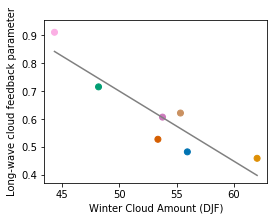

Mean squared error: 0.00
Coefficient of determination: 0.83


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y = np.array(out2['cloudlw_fb'])

x = np.array(apr_totcloud)

# create a linear regression model
model = LinearRegression()
model.fit(x.reshape(-1,1), y.reshape(-1,1))

# predict y from the data
x_new = np.linspace(min(x), max(x), 100)
y_new = model.predict(x_new[:, np.newaxis])
y_pred = model.predict(x.reshape(-1,1))

categories = np.array([0, 1, 2, 3, 4, 5, 6, 7])

colormap = np.array(sns.color_palette('colorblind'))

# plot the results
plt.figure(figsize=(4, 3))
ax = plt.axes()
ax.scatter(x, y, c=colormap[categories])
ax.plot(x_new, y_new,c='grey')#,linestyle='dashed')

ax.set_xlabel('Winter Cloud Amount (DJF)')
ax.set_ylabel('Long-wave cloud feedback parameter')

ax.axis('tight')

plt.show()

print('Mean squared error: %.2f' % mean_squared_error(y, y_pred))
print('Coefficient of determination: %.2f' % r2_score(y, y_pred))

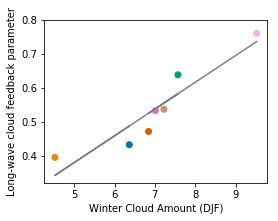

Mean squared error: 0.00
Coefficient of determination: 0.87


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y = np.array(out2['cloudlw_fb'])

x = np.array(list(dC_dict.values())).flatten()

# create a linear regression model
model = LinearRegression()
model.fit(x.reshape(-1,1), y.reshape(-1,1))

# predict y from the data
x_new = np.linspace(0.35, 0.85, 100)
x_new = np.linspace(4, 10, 100)
y_new = model.predict(x_new[:, np.newaxis])
y_pred = model.predict(x.reshape(-1,1))

categories = np.array([0, 1, 2, 3, 4, 5, 6, 7])

colormap = np.array(sns.color_palette('colorblind'))

# plot the results
plt.figure(figsize=(4, 3))
ax = plt.axes()
ax.scatter(x, y, c=colormap[categories])
# ax.plot(x_new, y_new,c='grey')#,linestyle='dashed')
ax.plot(x, y_pred,c='grey')#,linestyle='dashed')

ax.set_xlabel('Winter Cloud Amount (DJF)')
ax.set_ylabel('Long-wave cloud feedback parameter')

ax.axis('tight')

plt.show()

print('Mean squared error: %.2f' % mean_squared_error(y, y_pred))
print('Coefficient of determination: %.2f' % r2_score(y, y_pred))

In [ ]:
np.array(list(dC_dict.values())).flatten()